<a href="https://colab.research.google.com/github/KamonohashiPerry/MachineLearning/blob/master/deep-learning-from-scratch-2/Chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# リカレントニューラルネットワーク（RNN）

+ フィードフォワードのネットワーク
 + 流れが一方向のネットワーク
  + 入力信号が次の層へ信号を伝達し、信号を受け取った層はその次の層へ伝達し、そしてまた次の層へといったように一方向だけの信号伝達を行う。
   + 単純な構成で仕込みも理解しやすい。
   + 時系列データをうまく扱うことができない。

## 確率と言語モデル

### word2vecを確率の視点から眺める

+ これまでの表現（左右のウィンドウ）
$$P(w_t | w_{t-1}, w_{t+1})$$

+ 左のウィンドウだけ
$$P(w_t | w_{t-2}, w_{t-1})$$

+ 損失関数
$$ L = - \log P(w_t | w_{t-2}, w_{t-1}) $$



### 言語モデル
+ 単語の並びに対して確率を与える。

以下は乗法定理から導くことができる。
$$P(w_1, \dots , w_m) = P(w_m | w_1, \dots, w_{m-1})P(w_{m-1} | w_1, \dots, w_{m-2}) \dots P(w_3 | w_1, w_2)P(w_2 | w_1)P(w_1) \\
= \prod _{t=1}^{m}P(W_t | w_!, \dots, w_{t-1})$$



### CBOWモデルを言語モデルに
+ word2vecのCBOWモデルを無理やり言語モデルに適用するにはどうすればいいか？

$$P(w_1, \dots, w_m) = \prod_{t=1}^m P(w_t | w_1, \dots, w_{t-1}) \approx \prod_{t=1}^m P(w_t | w_{t-2}, w_{t-1}) $$

たった2つ過去の単語しか見れないので、できることに限界がある。

## RNNとは
+ 何度も繰り返される、循環されるニューラルネットワーク

### 循環するニューラルネットワーク
+ 循環するには閉じた経路が必要。
 + RNNレイヤはループする経路を持つ。

### ループの展開
+ 各時点のRNNレイヤは、そのレイヤへの入力と一つ目のRNNレイヤからの出力を受け取る。

$$h_t = \tanh (h_{t-1} W_h + x_t W_x + b)$$

過去の状態を持つという観点で、記憶力を持つレイヤとも考えることができる。

### Backpropagation Through Time(BPTT)
+ ループを展開したあとのRNNは誤差逆伝播法を使うことができる。
 + 最初に順伝播を行い、続いて逆伝播を行うことで、目的とする勾配を求めることができる。

+ 時間方向に展開したニューラルネットワークの誤差逆伝播法と呼ぶ。

+ 長い時系列になると学習するのに時間がかかる。
 + 時間サイズが長くなると逆伝播時の勾配が不安定になる。
 + 当然、メモリもたくさん使うことになる。

### Truncated BPTT
+ 大きな時系列データを扱う時に、ネットワークのつながりを適当な長さで断ち切るというもの。
+ 逆伝播のつながりは切断するが、順伝播のつながりは切断しない。
+ Truncated BPTTではデータをシーケンシャルに与えて学習を行う。これにより、順伝播のつながりを維持させながら、ブロック単位で誤差逆伝播法を適用できる。

### Truncated BPTTのミニバッチ学習
+ バッチ数に応じて、開始位置に関して処理をズラす必要がある。

## RNNの実装
RNNの順伝播
$$h_t = tanh(h_{t-1}W_h + x_t W_x + b)$$

In [0]:
class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b] # 各パラメータ
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),
                  np.zeros_like(b)] # 各パラメータに関する勾配
    self.cache = None # 逆伝播の計算時に使用する中間データ

  # 下からの入力、左からの入力を受け取る
  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
    h_next = np.tanh(t)

    self.cache = (x, h_prev, h_next)
    return h_next

  def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.cache

    dt = dh_next * (1 - h_next ** 2)
    db = np.sum(dt, axis=0)
    dWh = np.dot(h_prev.T, dt)
    dh_prev = np.dot(dt, Wh.T)
    dWx = np.dot(x.T, dt)
    dx = np.dot(dt, Wx.T)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev
    

### Time RNNレイヤの実装

In [0]:
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),
                  np.zeros_like(b)]
    self.layers = None

    self.h, self.dh = None, None
    self.stateful = stateful

  # 隠れ状態を設定する
  def set_state(self, h):
    self.h = h

  # 隠れ状態をリセットする
  def reset_state(self):
    self.h = None

  # 順伝播(下側からxs（T個分の時系列データをひとつにまとめたもの）を受け取る)
  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape # Nはバッチサイズ、Dは入力ベクトルの次元数
    D, H = Wx.shape

    self.layers = []
    # 出力用の変数を作成
    hs = np.empty((N, T, H), dtype='f')

    # 初期条件あるいはリセット
    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')

    # 時系列の数だけ繰り返し
    for t in range(T):
      layer = RNN(*self.params)
      self.h = layer.forward(xs[:, t, :], self.h)
      hs[:, t, :] = self.h
      self.layers.append(layer)

    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D, H = Wx.shape

    # 勾配の出力用の変数を作成
    dxs = np.empty((N, T, D), dtype='f')
    dh = 0
    grads = [0, 0, 0]
    # 順伝播の逆の順番で時系列で繰り返し。
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh = layer.backward(dhs[:, t, :] + dh) # 合算した勾配
      dxs[:, t, :] += grad

      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad

    self.dh = dh

    return dxs

## 時系列データを扱うレイヤの実装
RNN Language Model

### RNNLMの全体図
+ RNNLMはこれまで入力された単語を記憶し、それをもとに次に出現する単語を予測する。
+ RNNレイヤは過去から現在へとデータを継続的に流すことによって、過去の情報をエンコードして記憶することを可能にしている。

### Timeレイヤの実装

In [0]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


In [0]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelに該当するデータは損失を0にする
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする

        dx = dx.reshape((N, T, V))

        return dx

## RNNLMの学習と評価

### RNNLMの実装

In [5]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 378 (delta 0), reused 0 (delta 0), pack-reused 373
Receiving objects: 100% (378/378), 7.91 MiB | 12.21 MiB/s, done.
Resolving deltas: 100% (210/210), done.


In [6]:
cd deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


In [0]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # 重みの初期化
    embed_W = (rn(V, D) / 100).astype('f')
    rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
    rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
    rnn_b = np.zeros(H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    # レイヤの生成
    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeRNN(rnn_Wx, rnn_Wh. rnn_b, stateful=True),
                   TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.rnn_layerr = self.layers[1]

    # すべての重みと勾配をリストにまとめる
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, ts):
    for layer in self.layerrs:
      xs = layer.forward(xs)
    loss = self.loss_layer.forward(xs, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.rnn_layer.reset_state()


### 言語モデルの評価
+ 言語モデルの予測性能の良さ
 + パープレキシティ
   + 小さいほど良い

$$L = - \frac{1}{N} \sum_n \sum_k t_{nk} \log y_{nk} \\
perplexity = e^L$$

Done
corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 400.45
| epoch 2 | perplexity 279.04
| epoch 3 | perplexity 227.18
| epoch 4 | perplexity 216.92
| epoch 5 | perplexity 206.84
| epoch 6 | perplexity 203.97
| epoch 7 | perplexity 199.48
| epoch 8 | perplexity 197.11
| epoch 9 | perplexity 192.63
| epoch 10 | perplexity 193.11
| epoch 11 | perplexity 189.70
| epoch 12 | perplexity 193.42
| epoch 13 | perplexity 190.91
| epoch 14 | perplexity 191.50
| epoch 15 | perplexity 190.71
| epoch 16 | perplexity 187.80
| epoch 17 | perplexity 185.72
| epoch 18 | perplexity 182.44
| epoch 19 | perplexity 183.60
| epoch 20 | perplexity 185.13
| epoch 21 | perplexity 182.51
| epoch 22 | perplexity 179.65
| epoch 23 | perplexity 176.62
| epoch 24 | perplexity 177.85
| epoch 25 | perplexity 174.69
| epoch 26 | perplexity 174.86
| epoch 27 | perplexity 170.00
| epoch 28 | perplexity 167.48
| epoch 29 | perplexity 164.40
| epoch 30 | perplexity 159.20
| epoch 31 | perplexity 161.29
| e

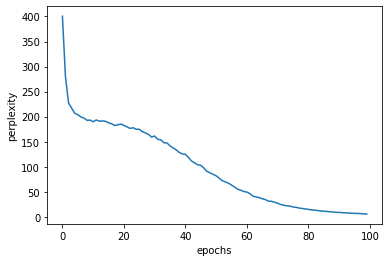

In [8]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

In [0]:
class RnnlmTrainer:
  def __init__(self, model, optimizer):
    self.model = model
    self.optimizer = optimizer
    self.time_idx = None
    self.ppl_list = None # パープレキシティ
    self.eval_interval = None
    self.current_epoch = 0

  # バッチ処理をズラすための関数
  def get_batch(self, x, t, batch_size, time_size):
    batch_x = np.empty((batch_size, time_size), dtype='i') # 入力
    batch_t = np.empty((batch_size, time_size), dtype='i') # 出力

    data_size = len(x)
    # インデックスを飛ばすため
    jump = data_size // batch_size
    offsets = [i * jump for i in range(batch_size)] # バッチの各サンプルの読み込み開始位置

    for time in range(time_size):
      for i, offset in enumerate(offsets):
        batch_x[i, time] = x[(offset + self.time_idx) % data_size]
        batch_t[i, time] = t[(offset + self.time_idx) % data_size]

      self.time_idx += 1
    return batch_x, batch_t

  def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
          max_grad=None, eval_interval=20):
    data_size = len(xs)
    max_iters = data_size // (batch_size * time_size)
    self.time_idx = 0
    self.ppl_list = []
    self.eval_interval = eval_interval
    model, optimizer = self.model, self.optimizer
    total_loss = 0
    loss_count = 0

    start_time = time.time()
    for epoch in range(max_epoch):
      for iters in range(max_iters):
        batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        params, grads = remove_duplicate(model.params, model.grads) # 共有された重みを1つに集約
        if max_grad is not None:
          clip_grads(grads, max_grad)
        optimizer.update(params, grads)
        total_loss += loss
        loss_count += 1

        # パープレキシティの評価
        if (eval_interval is not None) and (iter % eval_interval) == 0:
          ppl = np.exp(total_loss / loss_count)
          elapsed_time = time.time() - start_time
          print('| epoch %d | iter %d / %d | time %d[s] | perplexity %.2f'
                % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
          self.ppl_list.append(float(ppl))
          total_loss, loss_count = 0.0

      self.current_epoch += 1

  def plot(self, ylim=None):
    x = numpy.arange(len(self.ppl_list))
    if ylim is not None:
      plt.ylim(*ylim)
    plt.plot(x, self.ppl_list, label='train')
    plt.xlabel('iterations (x' + str(self.eval_interval) + ')' )
    plt.ylabel('perplexity')
    plt.show()

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 418.15
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 404.58
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 306.41
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 229.08
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 213.15
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 209.82
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 201.53
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 201.23
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 194.96
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 189.51
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 192.12
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 188.55
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 191.23
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 186.55
| epoch 15 |  iter 1 / 19 | time 1[s] | perplexity 184.70
| epoch 16 |  iter 1 / 19 | time 1[s] | perplexity 188.47
| epoch 17 |  iter 1 / 19 | time 1[s] | perplexity 187.44
| epoch 18 |  iter 1 / 

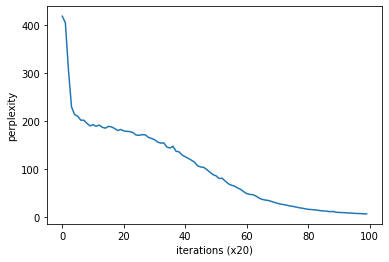

In [9]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 5  # RNNを展開するサイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # テスト用にデータセットを小さくする
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()